In [35]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
import seaborn as sns
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0,DenseNet121,ResNet50,VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [9]:
dir_names=["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]
images=[]
labels=[]

In [10]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images')

In [11]:
for dir in dir_names:
    os.chdir('./'+dir)
    imgs_names=os.listdir()
    for img_name in imgs_names:
        with Image.open(img_name) as image:
            image=np.array(image)
            images.append(image)
            labels.append(dir)
    os.chdir('../')

<Axes: ylabel='count'>

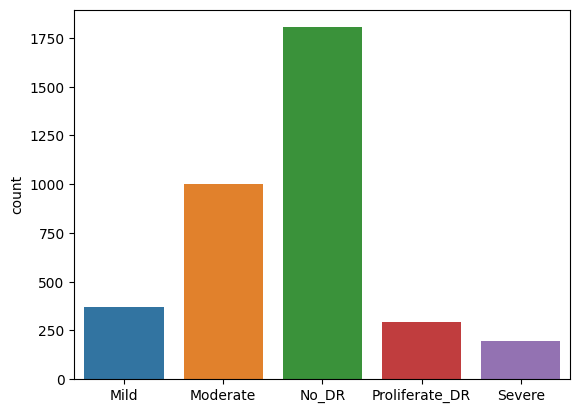

In [12]:
sns.countplot(x=labels)

In [15]:
(np.array(labels)=='Proliferate_DR').sum()

295

In [20]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')

In [21]:
max_images_per_label = 500
for dir in dir_names:
    os.chdir('./'+dir)
    imgs_names = os.listdir()
    count = labels.count(dir)  # Count how many images already exist for this label
    for img_name in imgs_names:
        if count < max_images_per_label:
            with Image.open(img_name) as image:
                image = np.array(image)
                images.append(image)
                labels.append(dir)
                count += 1
    os.chdir('../')

<Axes: ylabel='count'>

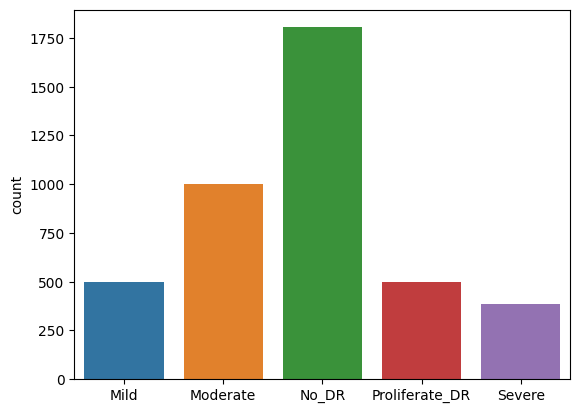

In [22]:
sns.countplot(x=labels)

In [25]:
threshold_per_class = 400
filtered_images = []
filtered_labels = []
class_counts = {label: 0 for label in set(labels)}
for image, label in zip(images, labels):
    if class_counts[label] < threshold_per_class:
        filtered_images.append(image)
        filtered_labels.append(label)
        class_counts[label] += 1

filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

<Axes: ylabel='count'>

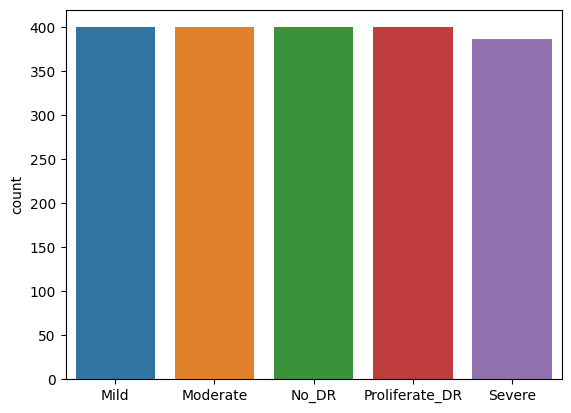

In [26]:
sns.countplot(x=filtered_labels)

In [27]:
len(filtered_images),len(filtered_labels),filtered_images.shape

(1986, 1986, (1986, 224, 224, 3))

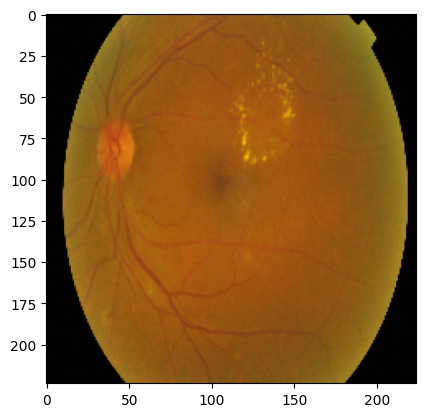

In [28]:
img=filtered_images[55]
plt.imshow(img)

In [29]:
def preprocess_image(image):
#     resized_image = cv2.resize(image, (224, 224))
#     gaussian = cv2.addWeighted(resized_image, 4, cv2.GaussianBlur(resized_image, (0,0), sigmaX), -4, 128)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l)
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    processed_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    return processed_image

(224, 224, 3)


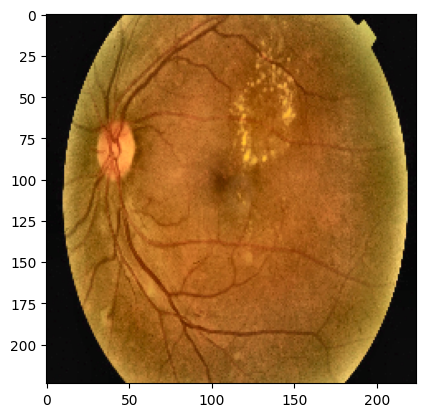

In [30]:
out=preprocess_image(img)
print(out.shape)
plt.imshow(out)

In [31]:
preprocessed_images=[preprocess_image(img) for img in filtered_images]
preprocessed_images=np.array(preprocessed_images)

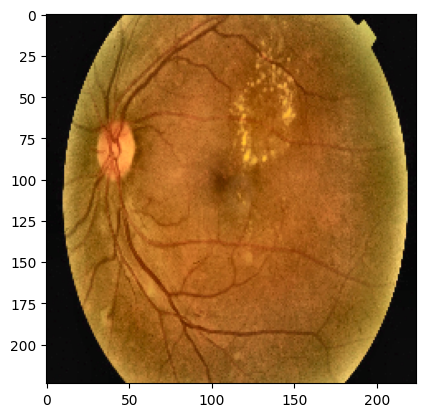

In [32]:
plt.imshow(preprocessed_images[55])

In [33]:
shuffled_indices = np.random.permutation(len(filtered_labels))
shuffled_preprocessed_images = preprocessed_images[shuffled_indices]
shuffled_filtered_labels = filtered_labels[shuffled_indices]

Moderate


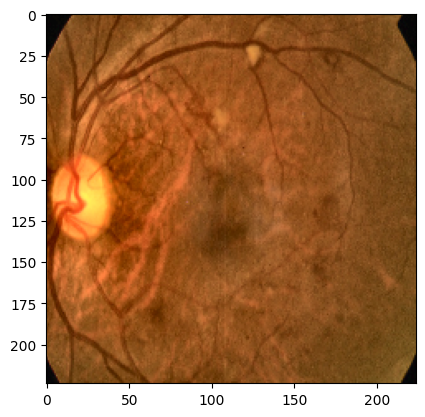

In [34]:
plt.imshow(shuffled_preprocessed_images[5])
print(shuffled_filtered_labels[5])

In [36]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(rotate=(-10, 10)), 
    iaa.Affine(scale=(0.8, 1.2)) 
])

In [37]:
augmented_images = []
augmented_labels = []

In [38]:
for image, label in zip(shuffled_preprocessed_images, shuffled_filtered_labels):
    augmented_image = seq(image=image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

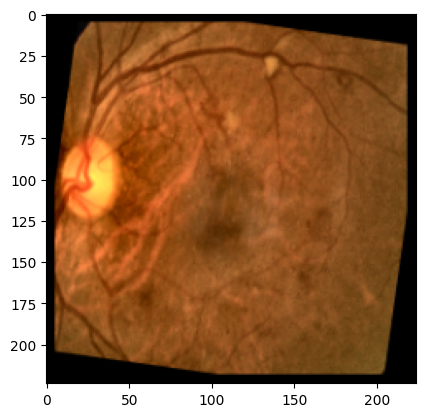

In [39]:
plt.imshow(augmented_images[5])

In [40]:
len(augmented_labels)

1986

In [41]:
final_images = np.concatenate((shuffled_preprocessed_images, augmented_images), axis=0)
final_labels = np.concatenate((shuffled_filtered_labels, augmented_labels), axis=0)
shuffled_indices = np.random.permutation(len(final_labels))
final_images = final_images[shuffled_indices]
final_labels = final_labels[shuffled_indices]

In [42]:
len(final_images)

3972

<Axes: ylabel='count'>

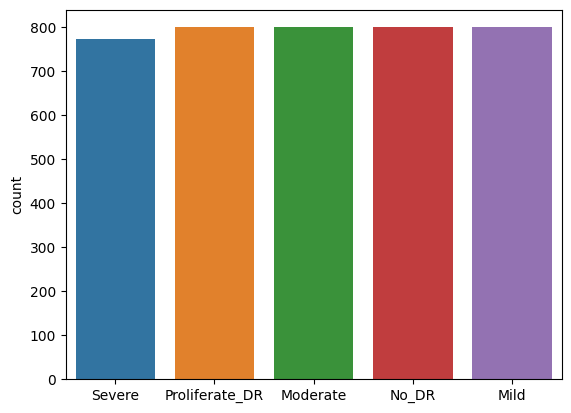

In [43]:
sns.countplot(x=final_labels)

In [44]:
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title('Label: ' + labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

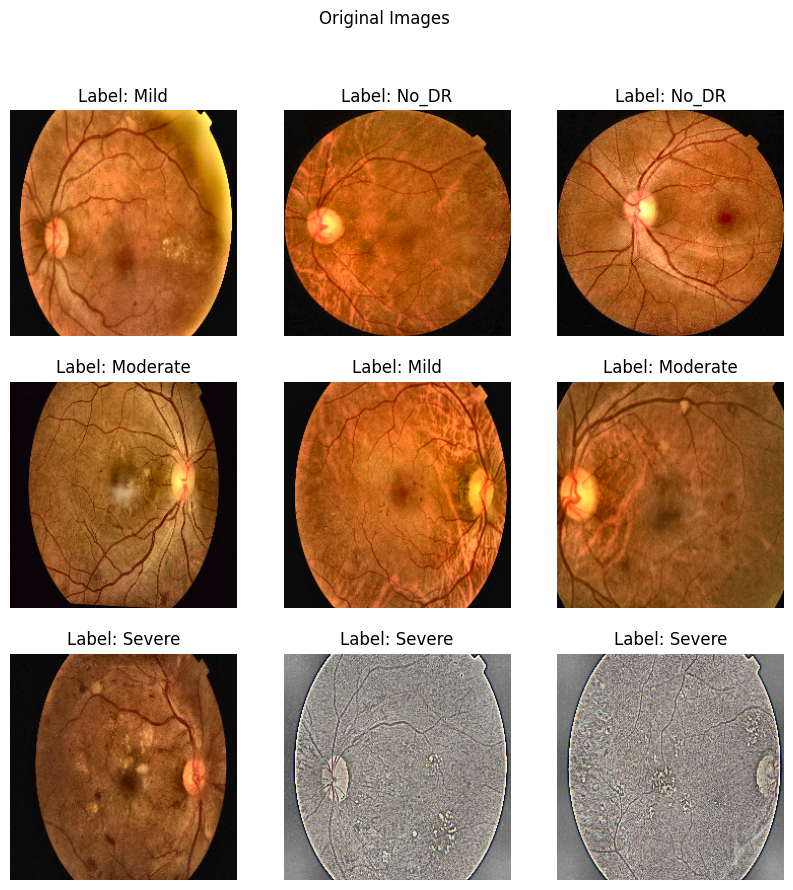

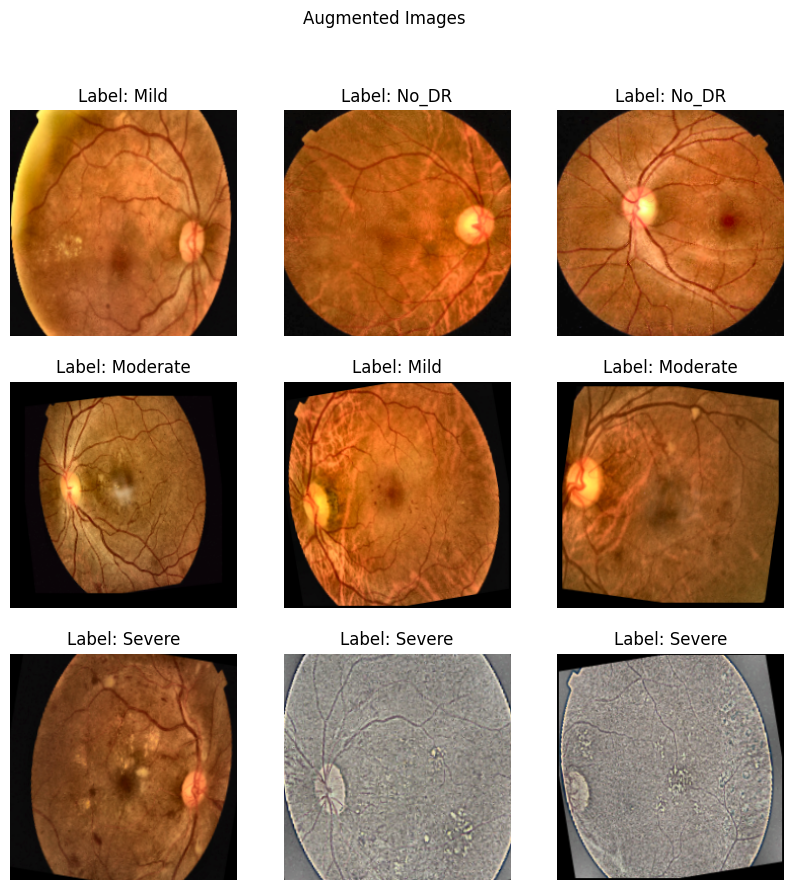

In [45]:
plot_images(shuffled_preprocessed_images[:9], shuffled_filtered_labels[:9], title='Original Images')
plot_images(augmented_images[:9], augmented_labels[:9], title='Augmented Images')

In [46]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

In [47]:
final_labels_encoded=encoder.fit_transform(final_labels)

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
x_train,x_test,y_train,y_test=train_test_split(final_images,final_labels_encoded,test_size=.2,stratify=final_labels_encoded,random_state=404)

In [109]:
def build_model(pre_trained):
    x = pre_trained.output
    x = layers.Flatten()(x)  # Flatten the output from the base model
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.33)(x)
    x = layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    predictions = layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=pre_trained.input, outputs=predictions)    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [86]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [87]:
model=build_model(base_model)

In [110]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

In [89]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=128)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.2751 - loss: 2.7611 - val_accuracy: 0.4201 - val_loss: 3.4015 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.3854 - loss: 2.6613 - val_accuracy: 0.4553 - val_loss: 2.6811 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4262 - loss: 2.4500 - val_accuracy: 0.5384 - val_loss: 2.1981 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4499 - loss: 2.2576 - val_accuracy: 0.5484 - val_loss: 2.0261 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4895 - loss: 2.0627 - val_accuracy: 0.5409 - val_loss: 1.9126 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5173 - loss: 1.9215 - val_accuracy: 0.6440 - val_loss: 1.7007 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5569 - loss: 1.7988 - va

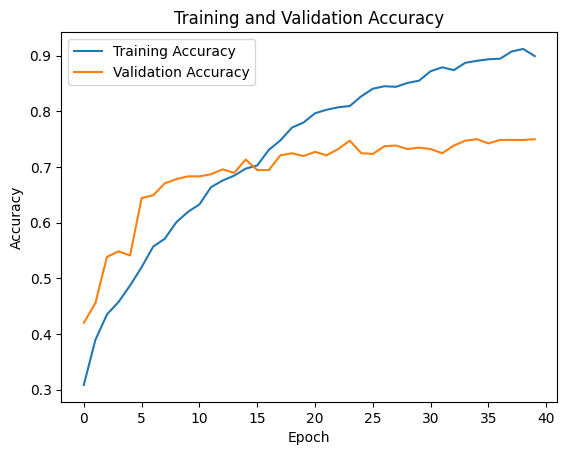

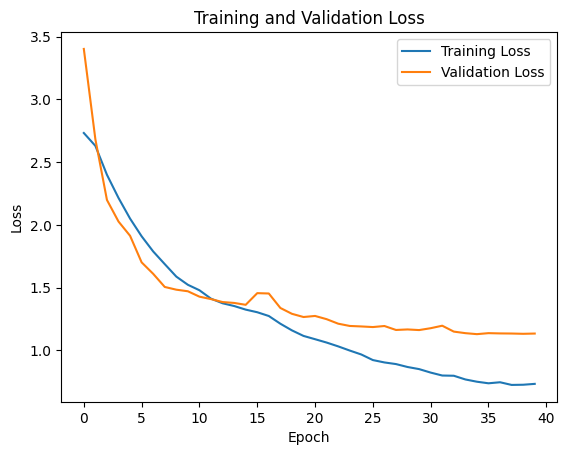

In [90]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
models=['EfficientNetB0','DenseNet','ResNet','VGG16']
accuracies=[]

In [92]:
accuracies.append(model.evaluate(x_test,y_test)[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7637 - loss: 1.1181


In [94]:
# model.save('/kaggle/working/my_model.h5')

In [95]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [98]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [99]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 97s 284ms/step - accuracy: 0.2729 - loss: 2.4897 - val_accuracy: 0.4818 - val_loss: 1.8820 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.3843 - loss: 2.0505 - val_accuracy: 0.4956 - val_loss: 1.7326 - learning_rate: 0.0010
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4188 - loss: 1.8950 - val_accuracy: 0.5421 - val_loss: 1.6382 - learning_rate: 0.0010
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4497 - loss: 1.7525 - val_accuracy: 0.4994 - val_loss: 1.6255 - learning_rate: 0.0010
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4677 - loss: 1.7236 - val_accuracy: 0.5472 - val_loss: 1.5244 - learning_rate: 0.0010
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.4795 - loss: 1.6443 - val_accuracy: 0.4994 - val_loss: 1.6179 - learning_rate: 0.0010
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5024 - loss: 

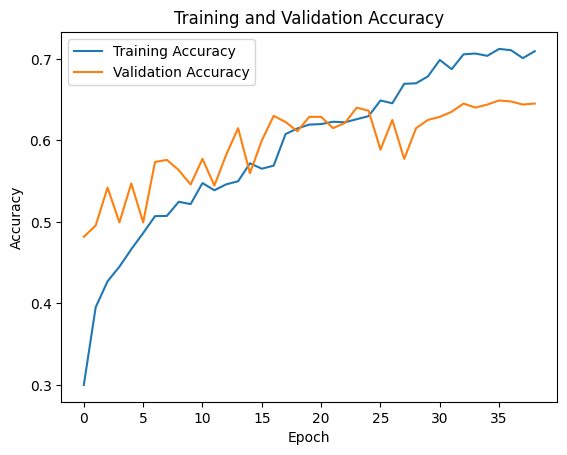

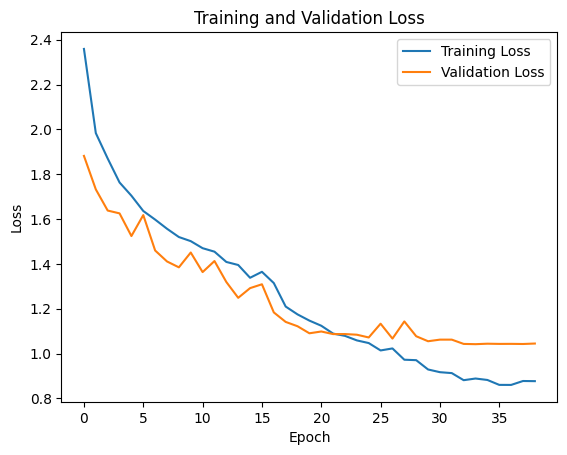

In [100]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [101]:
accuracies.append(model.evaluate(x_test,y_test)[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 643ms/step - accuracy: 0.6162 - loss: 1.0845


In [102]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [105]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [106]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 58s 158ms/step - accuracy: 0.2730 - loss: 2.9191 - val_accuracy: 0.3107 - val_loss: 2.7881 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4138 - loss: 2.5484 - val_accuracy: 0.5094 - val_loss: 2.0385 - learning_rate: 0.0010
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4654 - loss: 2.1158 - val_accuracy: 0.5874 - val_loss: 1.7303 - learning_rate: 0.0010
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5325 - loss: 1.7953 - val_accuracy: 0.5497 - val_loss: 1.6338 - learning_rate: 0.0010
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5334 - loss: 1.6753 - val_accuracy: 0.6176 - val_loss: 1.5100 - learning_rate: 0.0010
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5514 - loss: 1.5667 - val_accuracy: 0.6113 - val_loss: 1.4410 - learning_rate: 0.0010
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.5680 - loss: 

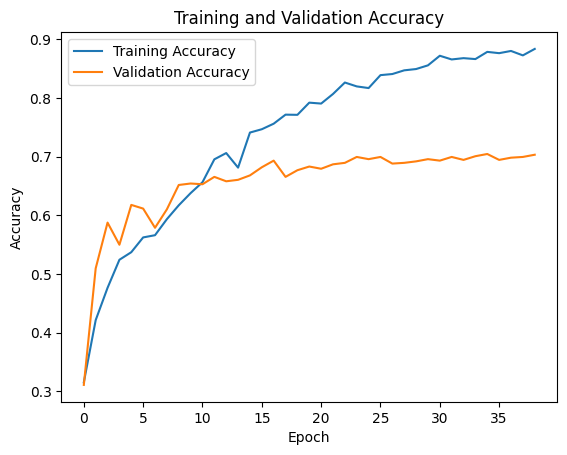

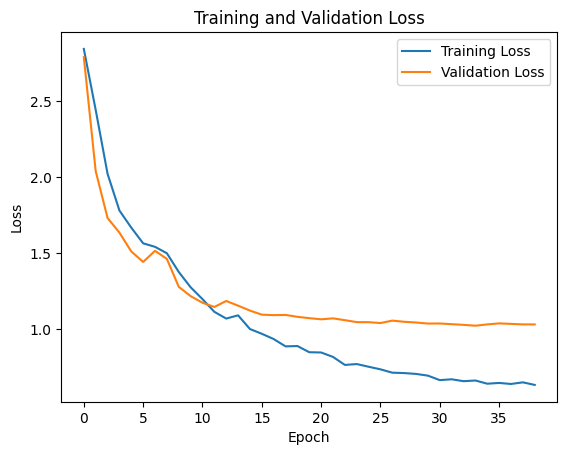

In [107]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
accuracies.append(model.evaluate(x_test,y_test)[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.6957 - loss: 1.0420


In [111]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=build_model(base_model)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [112]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50


2024-04-17 22:05:11.808041: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-04-17 22:05:11.808103: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-04-17 22:05:11.808119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-04-17 22:05:11.808137: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-04-17 22:05:11.808150: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-04-17 22:05:11.808160: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-04-17 22:05:11.808171: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-04-17 22:05:11.808181: E external/local_xla/xla

197/199 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2752 - loss: 2.3046

2024-04-17 22:05:34.335353: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.40131, expected 2.00221
2024-04-17 22:05:34.335407: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.97198, expected 2.57289
2024-04-17 22:05:34.335417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.88224, expected 2.48315
2024-04-17 22:05:34.335448: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5824: 2.95102, expected 2.55192
2024-04-17 22:05:34.335678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50092: 2.95205, expected 2.55296
2024-04-17 22:05:34.336040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 4.55134, expected 3.66346
2024-04-17 22:05:34.336063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.08774, expected 5.19985
2024-04-17 22:05:34.336074: E exte

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2759 - loss: 2.3034

2024-04-17 22:05:46.856367: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.18376, expected 3.42997
2024-04-17 22:05:46.856425: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.33565, expected 4.58186
2024-04-17 22:05:46.856442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.70509, expected 3.95129
2024-04-17 22:05:46.856460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.361, expected 4.60721
2024-04-17 22:05:46.856471: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.17522, expected 4.42143
2024-04-17 22:05:46.856482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.39461, expected 3.64082
2024-04-17 22:05:46.856492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.45438, expected 3.70059
2024-04-17 22:05:46.856503: E external/local_xla/xla/serv

199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 145ms/step - accuracy: 0.2762 - loss: 2.3028 - val_accuracy: 0.4403 - val_loss: 1.9403 - learning_rate: 0.0010
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4044 - loss: 2.1826 - val_accuracy: 0.4377 - val_loss: 1.9489 - learning_rate: 0.0010
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4525 - loss: 2.0497
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4526 - loss: 2.0494 - val_accuracy: 0.5031 - val_loss: 2.0050 - learning_rate: 0.0010
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4627 - loss: 1.8898 - val_accuracy: 0.5145 - val_loss: 1.8127 - learning_rate: 2.0000e-04
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5141 - loss: 1.7683 - val_accuracy: 0.5321 - val_loss: 1.7635 - learning_rate: 2.0000e-04
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5033 - loss: 1.7

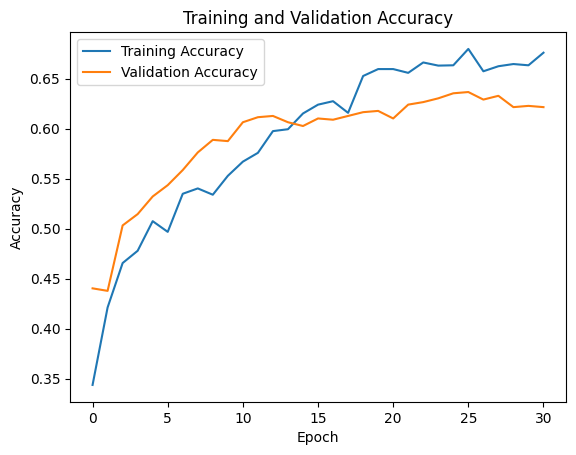

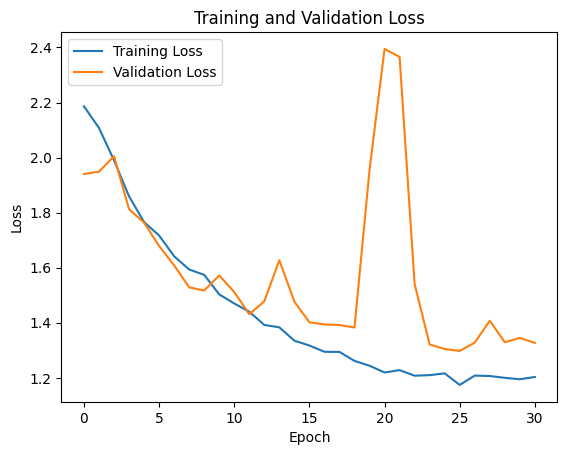

In [113]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [114]:
accuracies.append(model.evaluate(x_test,y_test)[1])

2024-04-17 22:10:06.776754: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-04-17 22:10:06.776811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-04-17 22:10:06.776824: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-04-17 22:10:06.776835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-04-17 22:10:06.776845: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-04-17 22:10:06.776864: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-04-17 22:10:06.776876: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-04-17 22:10:06.776888: E external/local_xla/xla/se

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6264 - loss: 1.2905

2024-04-17 22:10:24.518767: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.99165, expected 3.3217
2024-04-17 22:10:24.518824: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.28926, expected 4.61931
2024-04-17 22:10:24.518847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.06719, expected 4.39724
2024-04-17 22:10:24.518855: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.46955, expected 4.7996
2024-04-17 22:10:24.518863: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.74731, expected 3.07735
2024-04-17 22:10:24.518870: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.78108, expected 3.11113
2024-04-17 22:10:24.518878: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 5.36791, expected 4.69796
2024-04-17 22:10:24.518885: E external/local_xla/xla/

25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 583ms/step - accuracy: 0.6278 - loss: 1.2894


In [115]:
data = {'Model': models, 'Accuracy': accuracies}
df = pd.DataFrame(data)
df.head()

Model  Accuracy
0  EfficientNetB0  0.749686
1        DenseNet  0.640252
2          ResNet  0.700629
3           VGG16  0.644025

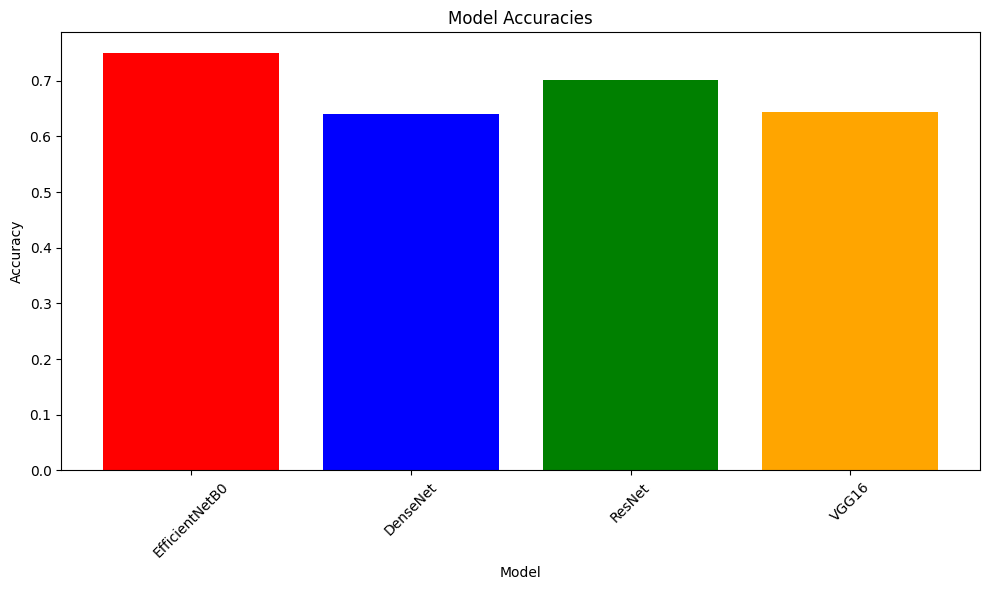

In [116]:
colors = ['red', 'blue', 'green', 'orange', 'purple']  
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Accuracy'], color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()